### data1a - whole cars vs. all damaged cars

In [1]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [33]:
import os
import h5py
import numpy as np
import pandas as pd

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras import Model

In [5]:
def load_vgg16(weights_path='vgg16_weights2.h5'):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='same'))

    # assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'

    if weights_path:
    # note: this chops off the last layers of VGG16

    # loads the weights of the VGG16 networks
    # note: when there is a complete match between model definition
    # and your weights savefile, you can simply call model.load_weights(filename)
        f = h5py.File(weights_path, 'r')
        nb_layers = len(f.attrs["layer_names"])
        print(f.keys())
        print(f.attrs.keys())
        print(len(model.layers))
        print(nb_layers)
        for k in range(nb_layers):
            if k >= len(model.layers):
                # we don't look at the last (fully-connected) layers in the savefile
                break
            g = f['layer_{}'.format(k)]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.layers[k].set_weights(weights)
        f.close()
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.')

    return model

In [3]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    model.summary()
    
    #model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=20,
                                            class_mode=None,
                                            shuffle=False)
    
    bottleneck_features_train = model.predict(generator, nb_train_samples)
    np.save(open(location+'/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=20,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples)
    np.save(open(location+'/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [4]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout()
    
    print("Best Model:") 
    print_best_model_results(hist)

In [17]:
def train_binary_model():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation = 'sigmoid')) # should activation be sigmoid for binary problem?
    model.summary()
    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [57]:
def finetune_binary_model():
    # model = load_vgg16()
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    # add the model on top of the convolutional base
    
    model.summary()
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:20]:
        layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='binary')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = model.fit(train_generator,
                              steps_per_epoch=nb_train_samples//10,
                              epochs=nb_epoch,
                              batch_size = 10,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//10,
                              validation_batch_size=10,
                              verbose=1,
                              callbacks=[checkpoint])
    
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [7]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [8]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [9]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

## Testing Image Generation

In [12]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest') # omitted rescaling to keep the images displayable

img = load_img('car-damage-dataset/data1a/training/00-damage/0039.JPEG') # this is a PIL image 
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory
os.makedirs('data1a_preview')
i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='data1a_preview', save_prefix='damage_car',
                         save_format='jpeg'):
    i +=1
    if i > 30:
        break # otherwise the generator would loop indefinitely

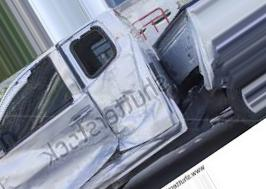

c to continue, q to quitq


'Finished for now.'

In [13]:
view_images('data1a_preview/', os.listdir('data1a_preview/'))

## Defining input data

In [14]:
# path to the model weights file
location = 'car-damage-dataset/data1a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
print(nb_train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)
print(nb_validation_samples)
nb_epoch = 50

1840
460


In [19]:
# do not rerun!!
save_bottleneck_features(location)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [21]:
d1a_model1, d1a_history1 = train_binary_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 8,389,121
Trainable params: 8,389,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silen

115/115 [==============================] - 3s 26ms/step - loss: 5.4113 - accuracy: 0.8630 - val_loss: 5.3176 - val_accuracy: 0.9087

Epoch 00024: val_accuracy did not improve from 0.91087
Epoch 25/50
115/115 [==============================] - 3s 24ms/step - loss: 5.3901 - accuracy: 0.8692 - val_loss: 5.3384 - val_accuracy: 0.8957

Epoch 00025: val_accuracy did not improve from 0.91087
Epoch 26/50
115/115 [==============================] - 3s 24ms/step - loss: 5.4087 - accuracy: 0.8624 - val_loss: 5.3184 - val_accuracy: 0.8957

Epoch 00026: val_accuracy did not improve from 0.91087
Epoch 27/50
115/115 [==============================] - 3s 24ms/step - loss: 5.3922 - accuracy: 0.8727 - val_loss: 5.3163 - val_accuracy: 0.9109

Epoch 00027: val_accuracy did not improve from 0.91087
Epoch 28/50
115/115 [==============================] - 3s 24ms/step - loss: 5.3856 - accuracy: 0.8866 - val_loss: 5.3278 - val_accuracy: 0.9022

Epoch 00028: val_accuracy did not improve from 0.91087
Epoch 29/50


In [59]:
d1a_model2, d1a_history2 = train_binary_model()

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
114/115 [============================>.] - ETA: 0s - loss: 5.7517 - accuracy: 0.5960WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x17fe42a60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

115/115 [==============================] - 3s 25ms/step - loss: 5.3989 - accuracy: 0.8679 - val_loss: 5.3459 - val_accuracy: 0.8870
Epoch 30/50
115/115 [==============================] - 3s 25ms/step - loss: 5.3867 - accuracy: 0.8661 - val_loss: 5.3253 - val_accuracy: 0.8978
Epoch 31/50
115/115 [==============================] - 3s 24ms/step - loss: 5.3483 - accuracy: 0.8916 - val_loss: 5.3227 - val_accuracy: 0.8978
Epoch 32/50
115/115 [==============================] - 3s 24ms/step - loss: 5.3634 - accuracy: 0.8816 - val_loss: 5.3360 - val_accuracy: 0.9065
Epoch 33/50
115/115 [==============================] - 3s 24ms/step - loss: 5.3804 - accuracy: 0.8803 - val_loss: 5.3216 - val_accuracy: 0.9043
Epoch 34/50
115/115 [==============================] - 3s 24ms/step - loss: 5.3918 - accuracy: 0.8512 - val_loss: 5.3207 - val_accuracy: 0.8978
Epoch 35/50
115/115 [==============================] - 3s 24ms/step - loss: 5.3724 - accuracy: 0.8811 - val_loss: 5.3208 - val_accuracy: 0.8935
Epoc

In [ ]:
d1a_model3, d1a_history3 = train_binary_model() 

In [ ]:
d1a_model4, d1a_history4 = train_binary_model() 

In [ ]:
d1a_model5, d1a_history5 = train_binary_model() 

In [ ]:
d1a_model6, d1a_history6 = train_binary_model() 

In [ ]:
d1a_model7, d1a_history7 = train_binary_model()

Best Model:
epoch: 49 , val_accuracy: 0.9130434989929199 , val_loss: 5.308770179748535


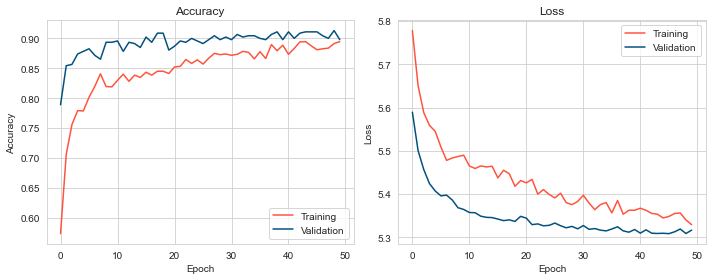

In [19]:
plot_metrics(d1a_history1) # rmsprop, sigmoid, no regularization

Best Model:
epoch: 49 , val_accuracy: 0.917391300201416 , val_loss: 5.3167033195495605


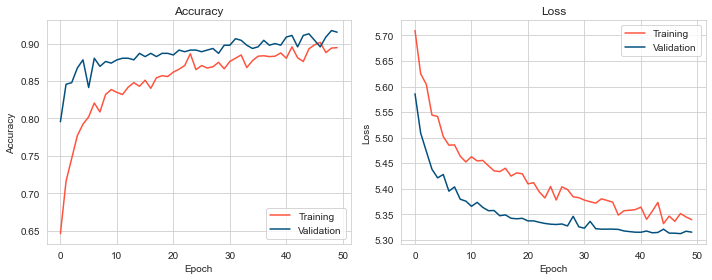

In [65]:
plot_metrics(d1a_history2) # rmsprop, sigmoid, with l2 regularization (0.01)

In [ ]:
plot_metrics(d1a_history3) # rmsprop, sigmoid, with double dense and dropout layers

In [ ]:
plot_metrics(d1a_history4) # rmsprop, sigmoid, with aggresive dropout (.75)

In [ ]:
plot_metrics(d1a_history5) # rmsprop, sigmoid, with l2 = 0.001

In [ ]:
plot_metrics(d1a_history6) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [ ]:
# WINNER
plot_metrics(d1a_history6) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [ ]:
plot_metrics(d1a_history7) # sgd with lr = 0.001 and decay 1e-6, sigmoid, with l2 = 0.001

## Fine Tuning

In [58]:
ft_model, ft_history = finetune_binary_model()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

184/184 [==============================] - 100s 545ms/step - loss: 5.9253 - accuracy: 0.6856 - val_loss: 5.3140 - val_accuracy: 0.9185

Epoch 00016: val_accuracy did not improve from 0.93207
Epoch 17/50
184/184 [==============================] - 100s 543ms/step - loss: 5.9083 - accuracy: 0.6725 - val_loss: 5.3153 - val_accuracy: 0.9212

Epoch 00017: val_accuracy did not improve from 0.93207
Epoch 18/50
184/184 [==============================] - 102s 553ms/step - loss: 5.8846 - accuracy: 0.7049 - val_loss: 5.3008 - val_accuracy: 0.9348

Epoch 00018: val_accuracy improved from 0.93207 to 0.93478, saving model to car-damage-dataset/data1a/ft_model.h5
Epoch 19/50
184/184 [==============================] - 100s 544ms/step - loss: 5.8586 - accuracy: 0.6842 - val_loss: 5.3271 - val_accuracy: 0.9158

Epoch 00019: val_accuracy did not improve from 0.93478
Epoch 20/50
184/184 [==============================] - 100s 546ms/step - loss: 5.9552 - accuracy: 0.6860 - val_loss: 5.3192 - val_accuracy: 0

Best Model:
epoch: 18 , val_accuracy: 0.9347826242446899 , val_loss: 5.300774097442627


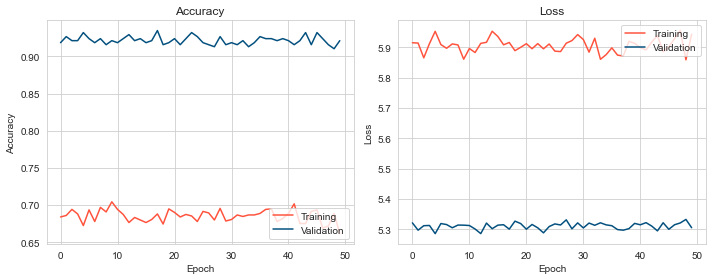

In [59]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

## Load Model Point

In [60]:
ft_model = load_model(location+'/ft_model.h5')

In [62]:
with open('car-damage-dataset/data1a/top_history.txt') as f:    
    top_history = json.load(f)

In [63]:
with open('car-damage-dataset/data1a/ft_history.txt') as f:    
    ft_history = json.load(f)

In [72]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:" )
    print_best_model_results(hist)

In [66]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [76]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print()
    print(classification_report(validation_labels, pred_labels))
    print()
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm 

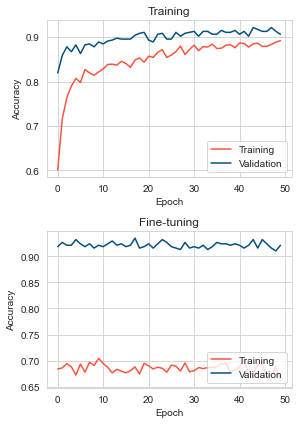

In [70]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 18 , val_accuracy: 0.9347826242446899 , val_loss: 5.300774097442627


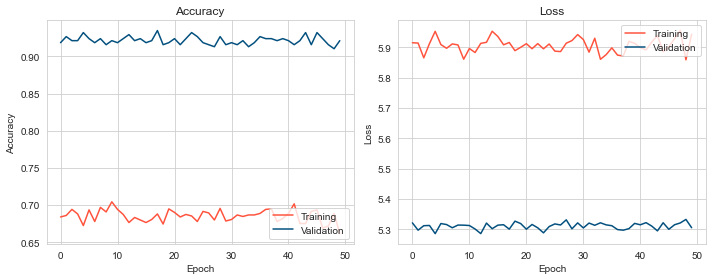

In [73]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [74]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1])

In [75]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 460 images belonging to 2 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/Users/bmkim/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



              precision    recall  f1-score   support

           0       0.89      0.96      0.92       230
           1       0.95      0.89      0.92       230

    accuracy                           0.92       460
   macro avg       0.92      0.92      0.92       460
weighted avg       0.92      0.92      0.92       460




In [77]:
heatmap_labels = ['Damaged', 'Whole']

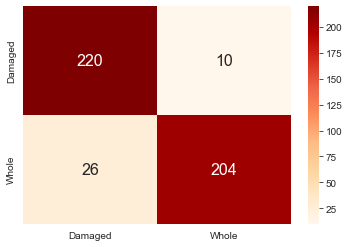

In [78]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

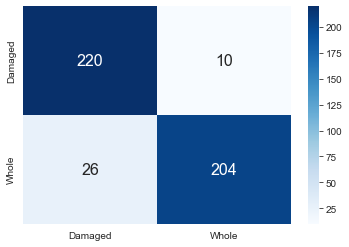

In [79]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [87]:
def car_categories_gate(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    print("Validating that damage exists...")
    print(pred)
    if pred[0][0] <=.5:

        print("Validation complete - proceed to location and severity determination")
    else:
        print("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print("Hint: Try zooming in/out, using a different angle or different lighting")

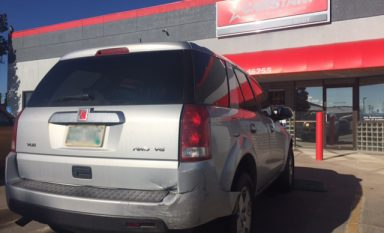

In [82]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

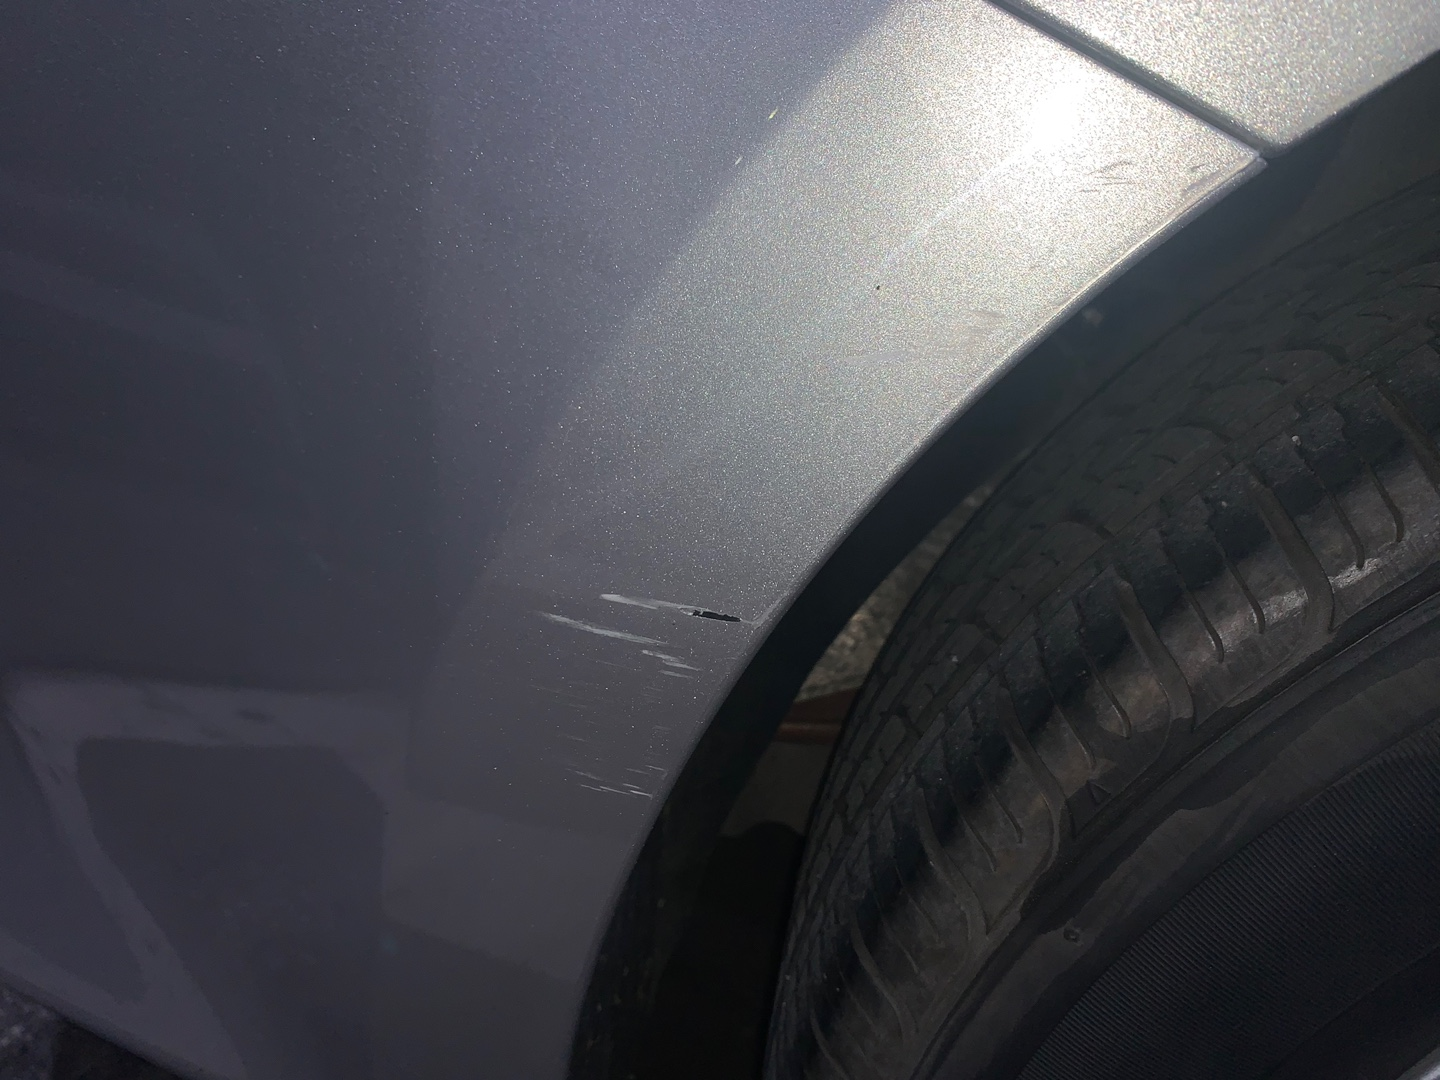

In [93]:
Image('https://blog.kakaocdn.net/dn/cDZI9a/btqJrjP5GT0/KlT4Hhpe2B4xMEleGh2uE0/img.jpg')

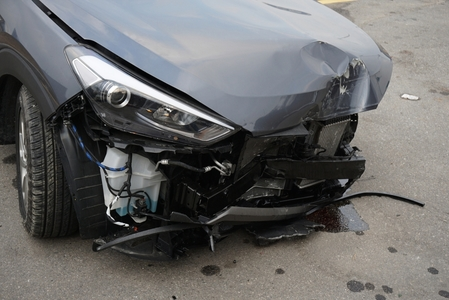

In [95]:
Image('https://cdn.crowdpic.net/list-thumb/thumb_l_B238155631E3C162468149CE8D46EDE0.jpg')

In [97]:
car_categories_gate('https://cdn.crowdpic.net/list-thumb/thumb_l_B238155631E3C162468149CE8D46EDE0.jpg', ft_model)

Validating that damage exists...
[[0.00667259]]
Validation complete - proceed to location and severity determination


In [94]:
car_categories_gate('https://blog.kakaocdn.net/dn/cDZI9a/btqJrjP5GT0/KlT4Hhpe2B4xMEleGh2uE0/img.jpg', ft_model)

Validating that damage exists...
[[0.24894103]]
Validation complete - proceed to location and severity determination


In [88]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Validating that damage exists...
[[0.19823343]]
Validation complete - proceed to location and severity determination


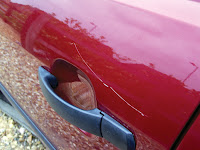

In [89]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [90]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Validating that damage exists...
[[0.07040262]]
Validation complete - proceed to location and severity determination


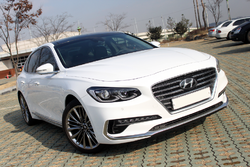

In [91]:
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Hyundai_grandeur_ig_3000cc_frontside.png/250px-Hyundai_grandeur_ig_3000cc_frontside.png')

In [92]:
car_categories_gate('https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Hyundai_grandeur_ig_3000cc_frontside.png/250px-Hyundai_grandeur_ig_3000cc_frontside.png', ft_model)

Validating that damage exists...
[[0.9933658]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


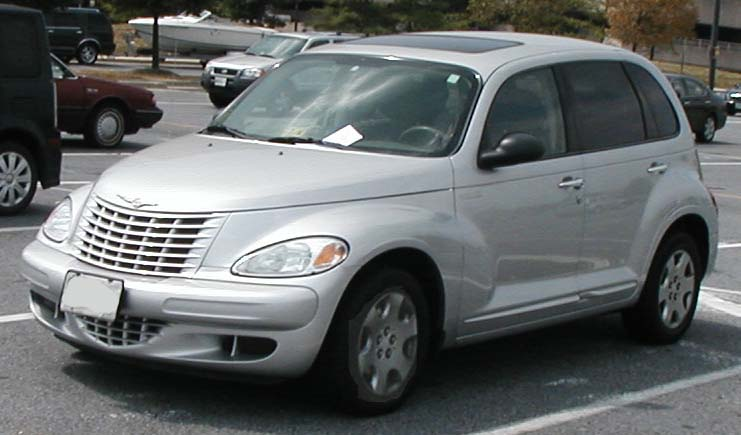

In [99]:
Image('https://upload.wikimedia.org/wikipedia/commons/d/dd/Chrysler-PTCruiser.jpg')

In [100]:
car_categories_gate('https://upload.wikimedia.org/wikipedia/commons/d/dd/Chrysler-PTCruiser.jpg', ft_model)

Validating that damage exists...
[[0.93513584]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


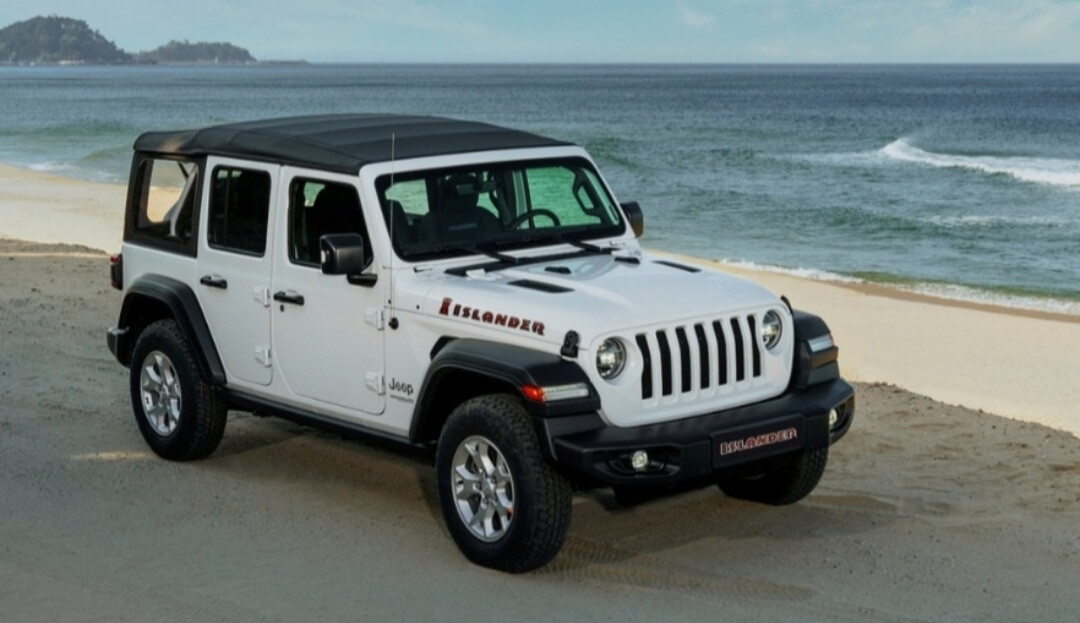

In [101]:
Image('https://blog.kakaocdn.net/dn/c3oO0U/btriX8NsAMg/0VVCgeoUxefRKB6NzmoLKk/img.jpg')

In [102]:
car_categories_gate('https://blog.kakaocdn.net/dn/c3oO0U/btriX8NsAMg/0VVCgeoUxefRKB6NzmoLKk/img.jpg', ft_model)

Validating that damage exists...
[[0.9928778]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


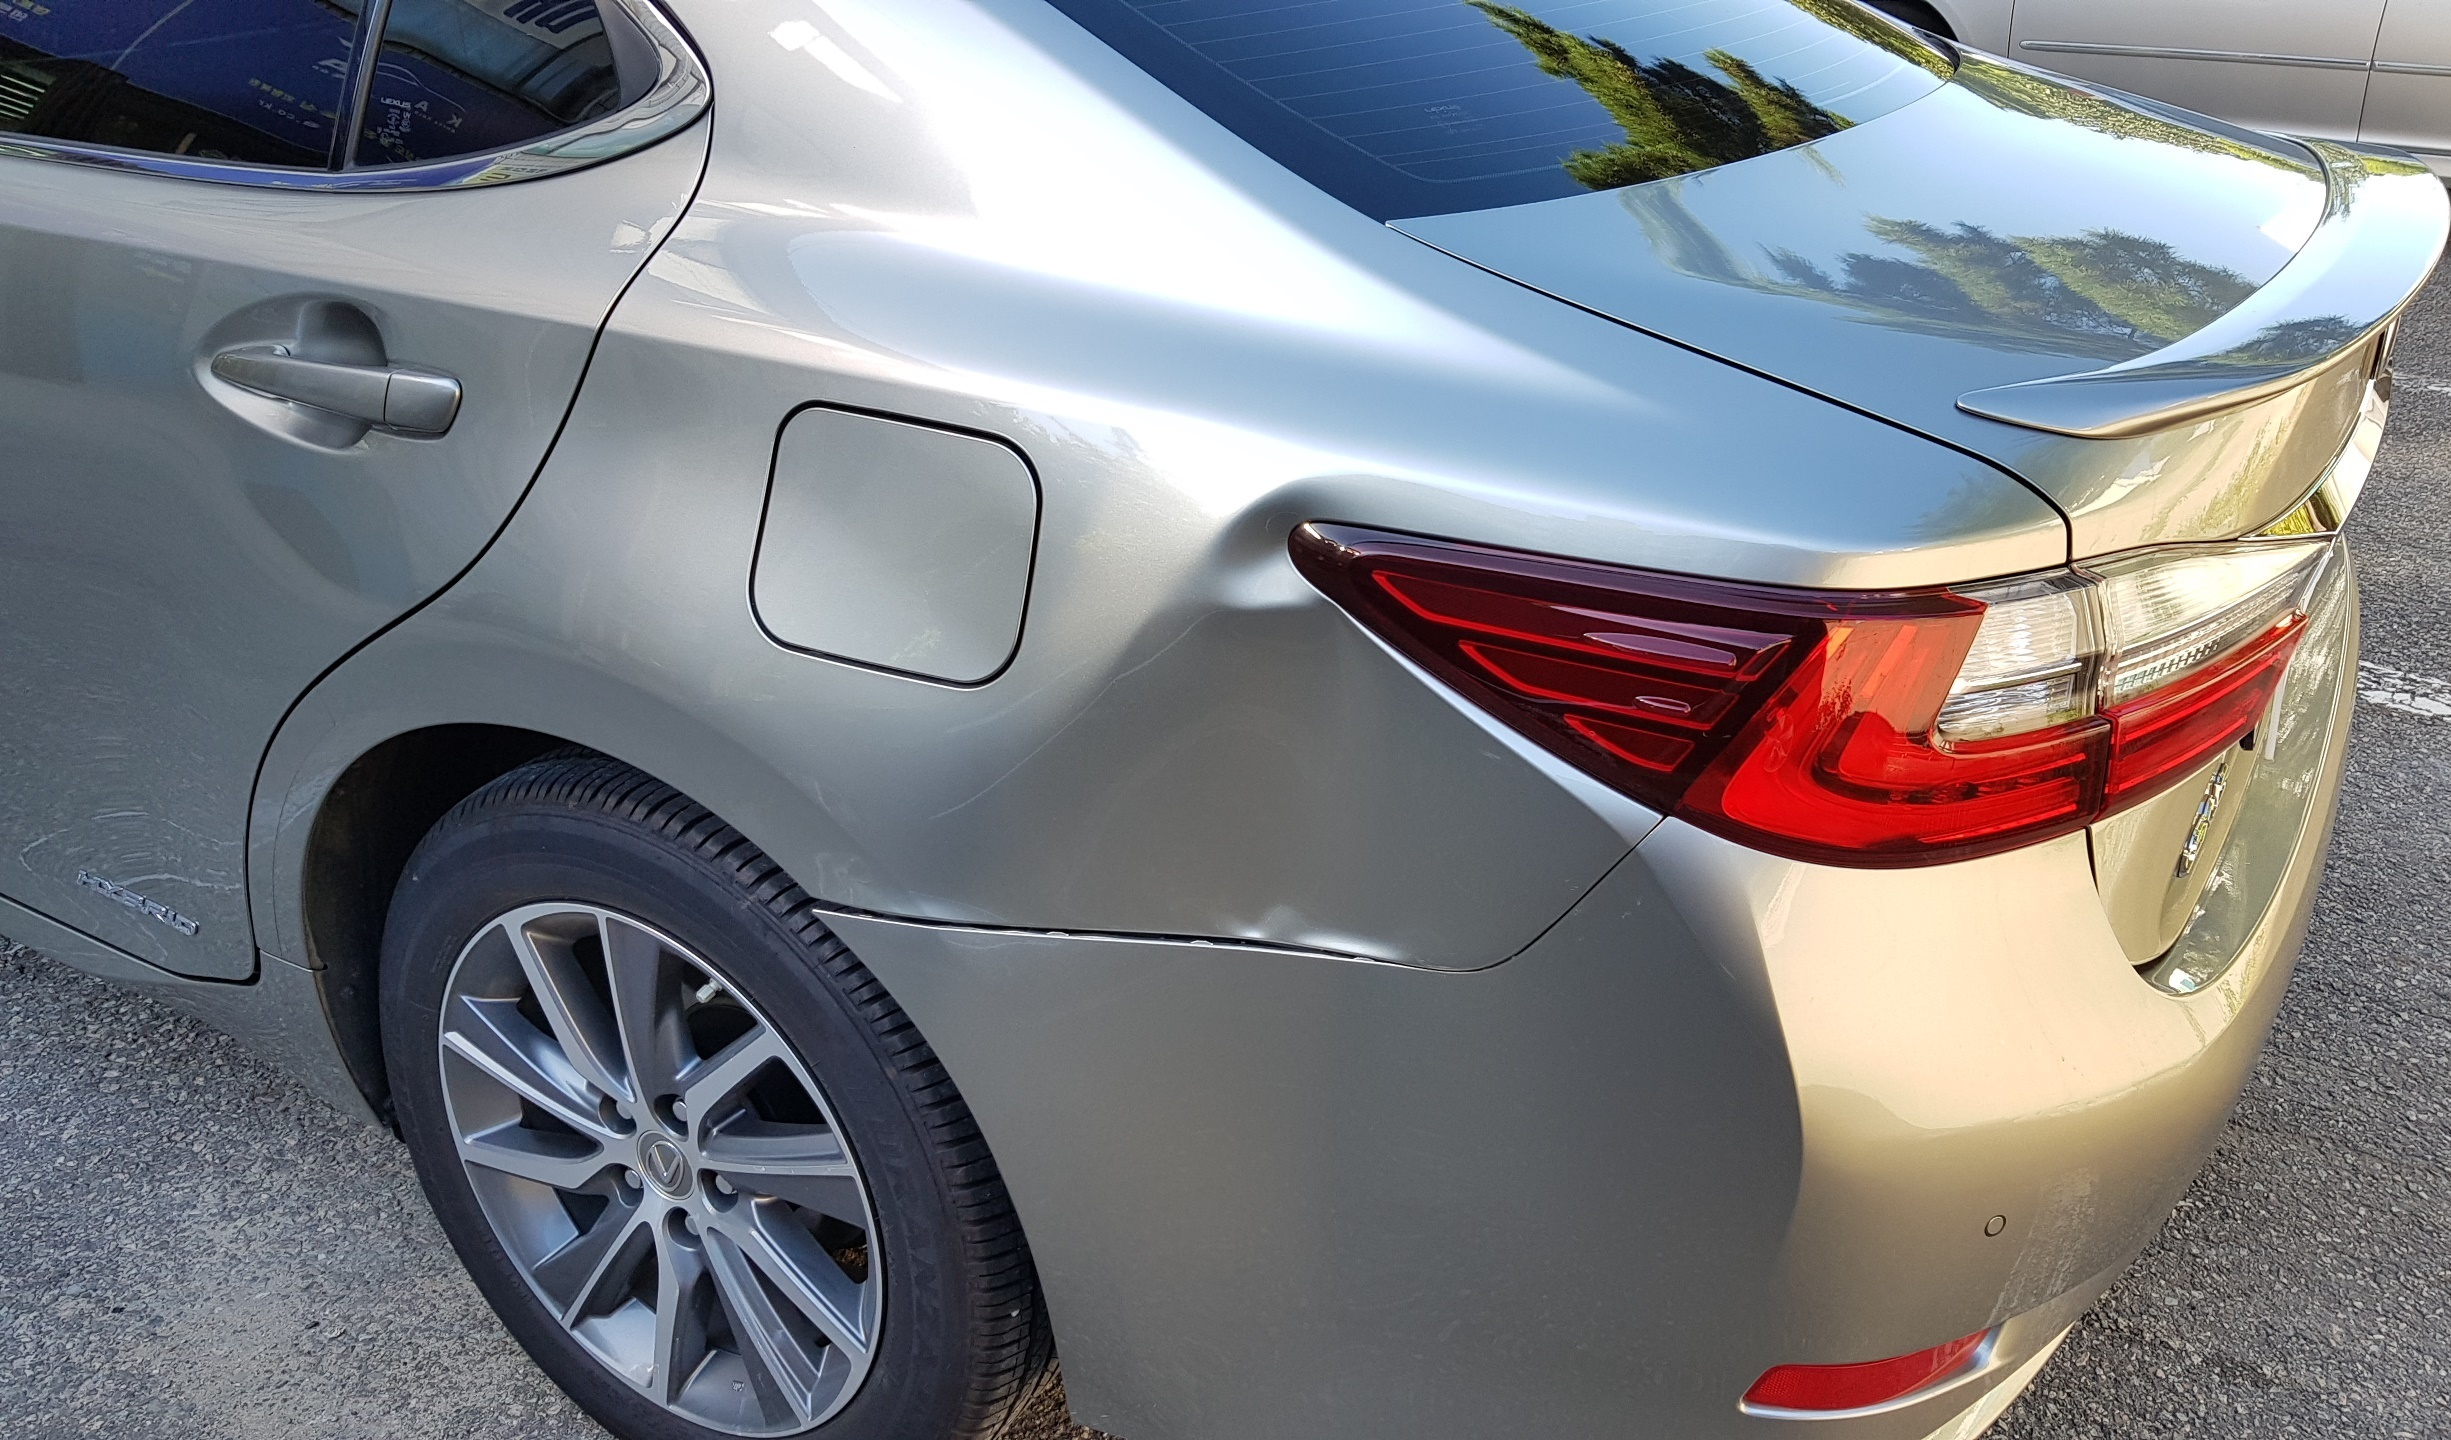

In [104]:
Image('https://modo-phinf.pstatic.net/20190826_221/1566810773449mMq4j_JPEG/mosauv6ibr.jpeg')

In [105]:
car_categories_gate('https://modo-phinf.pstatic.net/20190826_221/1566810773449mMq4j_JPEG/mosauv6ibr.jpeg', ft_model)

Validating that damage exists...
[[0.0362315]]
Validation complete - proceed to location and severity determination


## Looking at edge cases

In [106]:
def get_edge_cases(model, directory, exp_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred_prob = model.predict(x)
        if pred_prob <=0.5:
            pred = 0
        else:
            pred = 1
        if pred != exp_result:
            edge_list.append(name)
    return edge_list

In [107]:
evaluate_binary_model(ft_model, validation_data_dir, validation_labels)
# TP = 221, TN = 194, FP = 36, FN = 9
# 9 were predicted to be damaged but were actually whole
# 36 were predicted to be whole but were actually damaged

Found 460 images belonging to 2 classes.

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       230
           1       0.95      0.89      0.92       230

    accuracy                           0.92       460
   macro avg       0.92      0.92      0.92       460
weighted avg       0.92      0.92      0.92       460




array([[220,  10],
       [ 26, 204]])

In [108]:
fp = get_edge_cases(ft_model, 'car-damage-dataset/data1a/validation/00-damage/', 0)

In [109]:
len(fp)

10

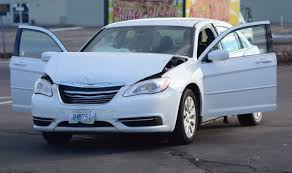

c to continue, q to quitc


In [112]:
view_images('car-damage-dataset/data1a/validation/00-damage/', fp)  # damaged, identifed as whole

In [111]:
fn = get_edge_cases(ft_model, 'car-damage-dataset/data1a/validation/01-whole/', 1)

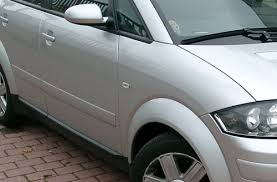

c to continue, q to quit


'Finished for now.'

In [115]:
view_images('car-damage-dataset/data1a/validation/01-whole/', fn) #whole, identified as damaged